In [12]:
import sklearn

In [13]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [14]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


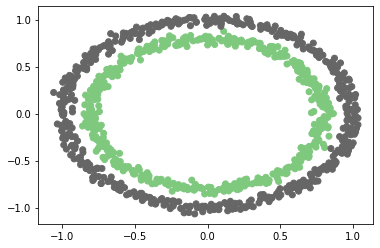

In [15]:
import matplotlib.pyplot as plt

plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.Accent_r)

In [16]:
X.shape, y.shape

((1000, 2), (1000,))

In [17]:
import torch
torch.__version__

'1.12.1+cu113'

In [18]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [19]:
X[:5]


tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [21]:
import torch 
from torch import nn

device= "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features =8)
    self.ReLU = nn.Sigmoid()
    self.layer_2 = nn.Linear(in_features =8, out_features=16)
    self.layer_3 = nn.Linear(in_features =16, out_features =1 )
    '''nn.Sequential(
    nn.Linear(in_features = 2, out_features=5),
    nn.ReLU(),
    nn.Linear(in_features = 5, out_features=1))
'''
  def forward(self,x):
    return self.layer_3(self.ReLU(self.layer_2(self.ReLU(self.layer_1(x)))))

model_0 =  CircleModelV0().to(device)

In [23]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (ReLU): Sigmoid()
  (layer_2): Linear(in_features=8, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)

In [24]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features=5),
    nn.Linear(in_features = 5, out_features=1)

).to(device)

In [25]:
model_1.state_dict()

OrderedDict([('0.weight', tensor([[-0.4754,  0.3255],
                      [ 0.6179, -0.2492],
                      [ 0.2393, -0.6834],
                      [ 0.1734,  0.7044],
                      [-0.1870,  0.6054]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0009, -0.7012, -0.1801, -0.0283, -0.4512], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0027, -0.0686, -0.0940, -0.4275, -0.0343]], device='cuda:0')),
             ('1.bias', tensor([0.3671], device='cuda:0'))])

In [26]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of prediction: {len(untrained_preds)}, Shape:{untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions:, \n{(untrained_preds[:10])}")
print(f"\n First 10 labels:\n{y_test[:10]}")

Length of prediction: 200, Shape:torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions:, 
tensor([[-0.0656],
        [-0.0681],
        [-0.0643],
        [-0.0659],
        [-0.0732],
        [-0.0748],
        [-0.0750],
        [-0.0765],
        [-0.0639],
        [-0.0684]], device='cuda:0')

 First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [27]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),lr = 0.1)

In [28]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [29]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0656],
        [-0.0681],
        [-0.0643],
        [-0.0659],
        [-0.0732]], device='cuda:0')

In [30]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4836],
        [0.4830],
        [0.4839],
        [0.4835],
        [0.4817]], device='cuda:0')

In [31]:
y_preds = torch.round(y_preds_probs)

y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(),y_preds_labels.squeeze()))
y_preds_labels.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train,X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)
  
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds =torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_preds)
    
  if epoch %10 ==0:
    print(f"Epoch:{epoch} |Loss:{loss:.5f}| Acc:{acc:.2f}% | Test loss:{test_loss:.5f} | Test acc:{test_acc:.2f}%")
     
     

Epoch:0 |Loss:0.69375| Acc:50.00% | Test loss:0.69354 | Test acc:50.00%
Epoch:10 |Loss:0.69319| Acc:50.00% | Test loss:0.69312 | Test acc:50.00%
Epoch:20 |Loss:0.69315| Acc:46.88% | Test loss:0.69309 | Test acc:47.00%
Epoch:30 |Loss:0.69315| Acc:50.00% | Test loss:0.69309 | Test acc:48.50%
Epoch:40 |Loss:0.69315| Acc:50.25% | Test loss:0.69309 | Test acc:48.00%
Epoch:50 |Loss:0.69315| Acc:50.62% | Test loss:0.69309 | Test acc:49.50%
Epoch:60 |Loss:0.69315| Acc:50.25% | Test loss:0.69309 | Test acc:49.50%
Epoch:70 |Loss:0.69315| Acc:50.25% | Test loss:0.69309 | Test acc:49.50%
Epoch:80 |Loss:0.69315| Acc:50.25% | Test loss:0.69309 | Test acc:49.50%
Epoch:90 |Loss:0.69315| Acc:50.25% | Test loss:0.69309 | Test acc:49.50%
Epoch:100 |Loss:0.69315| Acc:50.25% | Test loss:0.69309 | Test acc:49.50%
Epoch:110 |Loss:0.69315| Acc:50.38% | Test loss:0.69309 | Test acc:49.50%
Epoch:120 |Loss:0.69315| Acc:50.38% | Test loss:0.69309 | Test acc:49.50%
Epoch:130 |Loss:0.69315| Acc:50.62% | Test loss:0

In [33]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("helper_functions.py already exists,skip download")
else:
  print("Downloading helperfunction") 
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

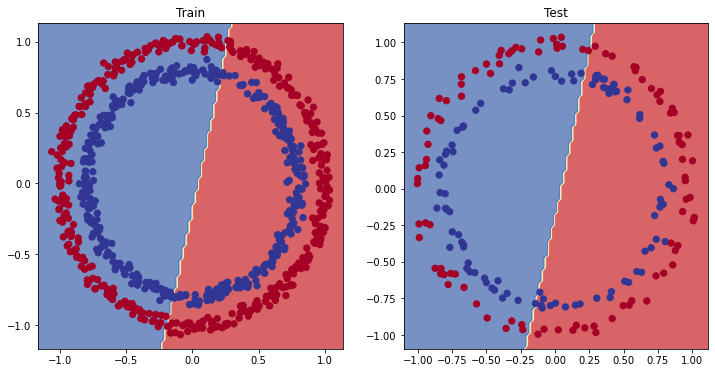

In [34]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

In [35]:
weight = 0.7
bias = 0.3
# Create data
start = 0
end = 1
step = 0.02
X_reg = torch.arange(start, end, step).unsqueeze(dim=1)
y_reg = weight * X_reg + bias

train_split = int(0.8 * len(X_reg)) # 80% of data used for training set, 20% for testing 
X_reg_train, y_reg_train = X_reg[:train_split], y_reg[:train_split]
X_reg_test, y_reg_test = X_reg[train_split:], y_reg[train_split:]

len(X_reg_train), len(y_reg_train), len(X_reg_test), len(y_reg_test)
  

(40, 40, 10, 10)

In [36]:
epocks =100

for epoch in range(epochs):
  model_0.train()